In [1]:
import json
import math
import os

import cv2
import numpy as np
from keras import layers
from tensorflow import keras
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf


In [3]:
%cd 'C:/Users/ADMIN/Contacts/KLTN'

/content/drive/.shortcut-targets-by-id/17VssmSEqr9Y_kcZQK6kTcJSB4McxSip6/deeplearning


In [ ]:
train_df = pd.read_csv('trainLabels_cropped.csv')

print(train_df.shape)
train_df.head(10)

(35108, 4)


,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
5,5,5,15_right,2
6,6,6,16_left,4
7,7,7,16_right,4
8,8,8,17_left,0
9,9,9,17_right,1


In [ ]:

train_df = train_df[['image','level']]

In [ ]:
train_df

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35103,44347_right,0
35104,44348_left,0
35105,44348_right,0
35106,44349_left,0


<Axes: xlabel='level'>

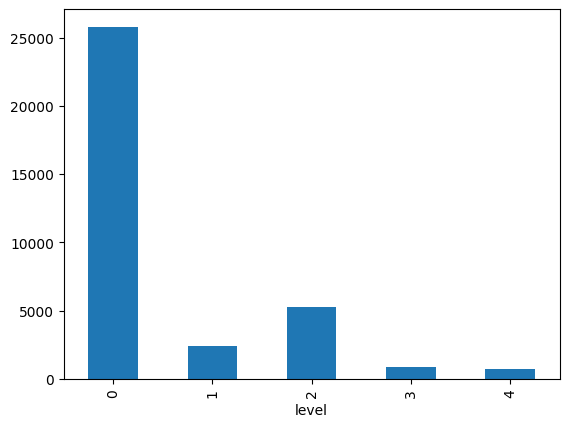

In [ ]:
train_df.groupby('level')['image'].count().plot(kind='bar')

In [ ]:
train_df['level'].value_counts()

level
0    25802
2     5288
1     2438
3      872
4      708
Name: count, dtype: int64

In [ ]:
# for i in range (len(train_df['level'])):
#   if train_df['level'][i] == 1 or train_df['level'][i]==2 or train_df['level'][i]==3 or train_df['level'][i]==4:
#     train_df['level'][i] = 1

# train_df

In [ ]:
# train_df['level'].value_counts()

In [ ]:
# train_df.to_csv('trainLabels.csv', index=False)

In [ ]:
# train_data = pd.read_csv('trainLabels.csv')

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'level']
        img = cv2.imread(f'resized_train/{image_path}.jpeg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

    plt.tight_layout()

In [ ]:


# display_samples(train_data)

Crop "chặt" ảnh: như 1 số ví dụ đã thấy bên trên, ta crop ảnh cho sát với viền của phần võng mạc, loại bỏ đi 1 phần background đen khá thừa thãi, và không giúp ích gì nhiều cho mô hình trong quá trình training sau này.

In [ ]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0: # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img


xử lý mất cân bằng


In [ ]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

Crop img

In [ ]:
# import glob
# import PIL.Image
# for i in range(len(train_df)):
#   image_path = train_data.loc[i,'image']
#   image_id = train_data.loc[i,'level']
#   img = cv2.imread(f'resized_train/{image_path}.jpeg')
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   new_img = crop_image_from_gray(img)
#   if image_id == 0:
#     PIL.Image.fromarray(new_img).save('./resized_train_crop/0/'+os.path.basename(str(image_path)+'.jpeg'))
#   elif image_id == 1:
#     PIL.Image.fromarray(new_img).save('./resized_train_crop/1/'+os.path.basename(str(image_path)+'.jpeg'))
#   # elif image_id == 2:
#   #   PIL.Image.fromarray(new_img).save('./resized_train_crop/Moderate/'+os.path.basename(str(image_path)+'.jpeg'))
#   # elif image_id == 3:
#   #   PIL.Image.fromarray(new_img).save('./resized_train_crop/Severe/'+os.path.basename(str(image_path)+'.jpeg'))
#   # elif image_id == 4:
#   #   PIL.Image.fromarray(new_img).save('./resized_train_crop/Proliferative_DR/'+os.path.basename(str(image_path)+'.jpeg'))

In [ ]:
# No_DR_data = train_data[train_data['level']==0]
# Mild_data = train_data[train_data['level']==1]
# Moderate_data = train_data[train_df['level']==2]
# Severe_data = train_data[train_df['level']==3]
# Proliferative_DR_data = train_data[train_df['level']==4]


In [ ]:

# n = train_data['level'].value_counts().min()
# n

In [ ]:
# No_DR_train, No_DR_test = train_test_split(No_DR_data, test_size=0.15, random_state=42)
# Mild_train, Mild_test = train_test_split(Mild_data, test_size=0.15, random_state=42)
# Moderate_train, Moderate_test= train_test_split(Moderate_data, test_size=0.15, random_state=42)
# Severe_train, Severe_test =  train_test_split(Severe_data, test_size=0.15, random_state=42)
# Proliferative_DR_train, Proliferative_DR_test = train_test_split(Proliferative_DR_data, test_size=0.15, random_state=42)

In [ ]:
# No_DR_train = No_DR_data.sample(n)
# Mild_train = Mild_data.sample(n)
# Moderate_train= Moderate_data.sample(n)
# Severe_train =  Severe_data.sample(n)
# Proliferative_DR_train = Proliferative_DR_data.sample(2500,replace=True)

In [ ]:
# train_clean = pd.concat([No_DR_train,Mild_train,Moderate_train,Severe_train,Proliferative_DR_train], ignore_index = True)
# # test_clean = pd.concat([No_DR_test,Mild_test,Moderate_test,Severe_test,Proliferative_DR_test], ignore_index = True)

In [ ]:
# train_clean['level'].value_counts()

In [ ]:





# train_clean.to_csv('trainLabelsClean.csv', index=False)

In [ ]:
# test_clean['level'].value_counts()

In [ ]:
# test_clean.to_csv('testLabelsClean.csv', index=False)

0 - No DR: Bình thường
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR: giai đoạn bệnh lý nặng nhất.

In [ ]:
# i_train_1, i_test = train_test_split(train_clean, test_size=0.15, random_state=42)
# i_train,i_val = train_test_split(i_train_1, test_size=0.15, random_state=42)

i_train, i_test = train_test_split(train_df, test_size=0.2, random_state=42)
# i_train,i_val = train_test_split(i_train_1, test_size=0.15, random_state=42)

In [ ]:
i_train.to_csv('train.csv', index=False)
# i_val.to_csv('val.csv', index=False)
i_test.to_csv('test.csv', index=False)

In [ ]:
i_train = pd.read_csv('train.csv')

In [ ]:
i_train, i_val = train_test_split(i_train, test_size=0.16, random_state=42)

In [ ]:
i_train.to_csv('train.csv', index=False)
i_val.to_csv('val.csv', index=False)

In [ ]:
def make_cont(img, to_gray=False, IMG_SIZE=224):
    """
    Increase image contract
    """
    if to_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cimg = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), IMG_SIZE / 10), -4, 128)
    return cimg


In [4]:
i_train = pd.read_csv('train.csv')

In [5]:
i_train['level'].value_counts()

level
0    17295
2     3581
1     1641
3      605
4      470
Name: count, dtype: int64

In [ ]:
import glob
import PIL.Image
for i in i_train.index:
  image_path = i_train.loc[i,'image']
  image_id = i_train.loc[i,'level']
  img = cv2.imread(f'resized_train/{image_path}.jpeg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  new_img = crop_image_from_gray(img)
  new_img = make_cont(new_img)

  print(i)
  if image_id == 0:
    PIL.Image.fromarray(new_img).save('./train/No_DR/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 1:
    PIL.Image.fromarray(new_img).save('./train/Mild/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 2:
    PIL.Image.fromarray(new_img).save('./train/Moderate/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 3:
    PIL.Image.fromarray(new_img).save('./train/Severe/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 4:
    PIL.Image.fromarray(new_img).save('./train/Proliferative_DR/'+os.path.basename(str(image_path)+'.jpeg'))

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
18747
18748
1

In [ ]:
i_val = pd.read_csv('val.csv')

In [ ]:
import glob
import PIL.Image
for i in i_val.index:
  image_path = i_val.loc[i,'image']
  image_id = i_val.loc[i,'level']
  img = cv2.imread(f'resized_train/{image_path}.jpeg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  new_img = crop_image_from_gray(img)
  new_img = make_cont(new_img)
  print(i)
  if image_id == 0:
    PIL.Image.fromarray(new_img).save('./vali/No_DR/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 1:
    PIL.Image.fromarray(new_img).save('./vali/Mild/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 2:
    PIL.Image.fromarray(new_img).save('./vali/Moderate/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 3:
    PIL.Image.fromarray(new_img).save('./vali/Severe/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 4:
    PIL.Image.fromarray(new_img).save('./vali/Proliferative_DR/'+os.path.basename(str(image_path)+'.jpeg'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
i_test = pd.read_csv('test.csv')

In [ ]:
import glob
import PIL.Image
for i in i_test.index:
  image_path = i_test.loc[i,'image']
  image_id = i_test.loc[i,'level']
  img = cv2.imread(f'resized_train/{image_path}.jpeg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  new_img = crop_image_from_gray(img)
  new_img = make_cont(new_img)
  print(i)
  if image_id == 0:
    PIL.Image.fromarray(new_img).save('./test/No_DR/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 1:
    PIL.Image.fromarray(new_img).save('./test/Mild/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 2:
    PIL.Image.fromarray(new_img).save('./test/Moderate/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 3:
    PIL.Image.fromarray(new_img).save('./test/Severe/'+os.path.basename(str(image_path)+'.jpeg'))
  elif image_id == 4:
    PIL.Image.fromarray(new_img).save('./test/Proliferative_DR/'+os.path.basename(str(image_path)+'.jpeg'))

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
221